Modelacion de Sistemas Multiagentes
* Diego Rosas A01634154
* Alejandro Pizarro A01633784
* Jueves 18 de Agosto de 2022


In [54]:
#%pip install agentpy seaborn 

In [55]:
# Model design
from pickle import DICT
import agentpy as ap
import random

MOVES = [(1,0), (0,1), (-1, 0), (0,-1)]

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython


In [56]:
class RoomModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        self. robot = ap.AgentList(self, 1)
        self.trash = ap.AgentList(self, 100)

        # Create grid (forest)
        self.room = ap.Grid(self, [50, 50], track_empty=True)
        self.room.add_agents(self.robot, [(1,1)])
        self.room.add_agents(self.trash, random=True)

        # Initiate a dynamic variable for all trees
        # Condition 0: Robot, 1: Basura, 2: Basura (clean)
        self.robot.type_agent = 0
        self.trash.type_agent = 1
    

    def step(self):

        robots = self.robot

        # Spread fire
        for robot in robots:
            for neighbor in self.room.neighbors(robot):
                if neighbor.type_agent == 1:
                    neighbor.type_agent = 2
                    break
            else:
                self.room.move_by(robot, random.choice(MOVES))
        
        
        trash_pending = self.trash.select(self.trash.type_agent == 1)
        # Stop simulation if no fire is left
        if len(trash_pending) == 0:
            self.stop()

    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.trash.select(self.trash.type_agent == 2))
        self.report('Percentage of trash',
                    burned_trees / len(self.trash))

In [57]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.room.attr_grid('type_agent')
    color_dict = {0:'black', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.trash.select(model.trash.type_agent == 1))}")

fig, ax = plt.subplots()
model = RoomModel({'steps': 100})
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

In [58]:
# Prepare parameter sample
parameters = {
    'Dirty cell density': ap.Range(0.2, 0.6),
    'size': 100
}
sample = ap.Sample(parameters, n=30)

In [59]:
# Perform experiment
exp = ap.Experiment(ForestModel, sample, iterations=40)
results = exp.run()

NameError: name 'ForestModel' is not defined

In [ ]:
# Save and load data
results.save()
results = ap.DataDict.load('ForestModel')

Data saved to ap_output/ForestModel_3
Loading from directory ap_output/ForestModel_3/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful


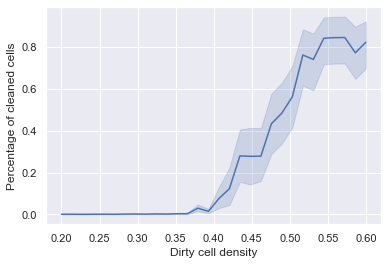

In [ ]:
# Plot sensitivity
sns.set_theme()
sns.lineplot(
    data=results.arrange_reporters(),
    x='Dirty cell density',
    y='Percentage of cleaned cells'
);